In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#why are we using a modulo operator ever?
#what is role of gpe_bl and gpi_bl, will likely require reading...

#the manella paper has it set up that even upon action plan initation, only one thalamic unit is ever becoming active...
#if we assume that the most salient input will always have an salience above 50% of the maximal input this become easier, than a salience of 0.5 just needs to be set st. it completly blocks all other action plans

#things changed on november 9th
# - updated non-linearity to actually apply a non-linearity
# - set so tonic GPi activity keeps Tha activity close to 0...
# - set w_inp_ctx st that the maximal driven activity cannot be greater than 0.5, thus the recurrant cortical activity can be of equal strength or greater... prevents switching from a selected action plan
#   - currently set so that a salience of 1 drives a striatal response of 0.4
#also making note, it may be helpful if we have a constant amount of salience... for example if each node has its salience set as the posterior probability that it will produce the least error, we can have a constant amount of salience coming in, this cant make anything more difficult at least

# - maybe we can get around the cortex feedback issue if we normalize all cortical feedback to have a sum of one? This makes it so the input and cortex recurrant activity are actually the same input
# - also maybe we normalize everything so the largest salience is always at the same number? also makes things easier

# logic from november 12th
# -initial exterior saliences will not effect the STN
# -thus the total input to the STR from the input will always be 1 total, this means that all total input at all layers will be equivalent no matter what the makeup of the trial, most importantly, the input to the STN will be constant...
# -have it set st. any salience >0.5 floors the GPi, and that this will not be "unfloored" by the STN
# -the STN will then be set st. it "unfloors" all saliences <0.5
# -any GPi unit that is not floored, will floor the Tha, thus there is only one active channel. 

Ask why we are trying to do an attractor in the first place...

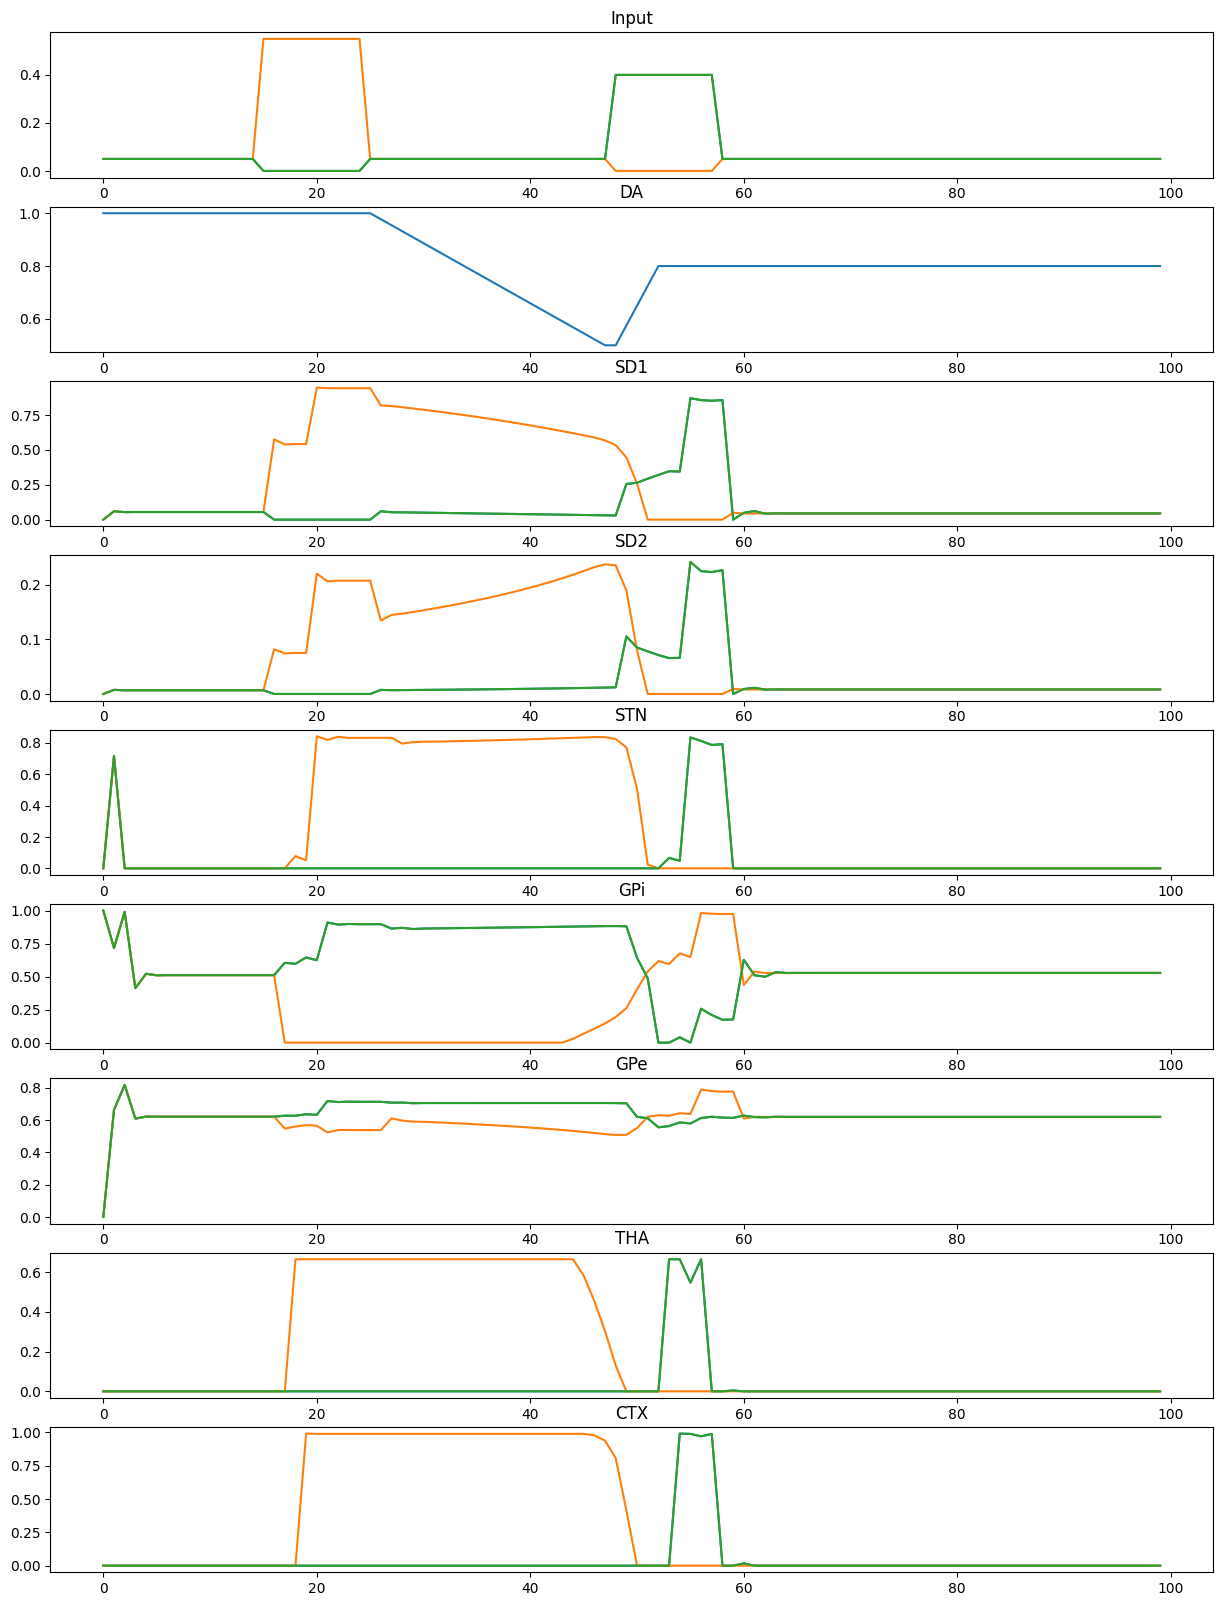

In [75]:
class b_ganglia:
    def __init__(self,n_loops,time_steps):

        self.n_loops=n_loops

        #activations for all units
        self.a_sd1 = np.zeros((time_steps, n_loops))
        self.a_sd2 = np.zeros((time_steps, n_loops))
        self.a_stn = np.zeros((time_steps, n_loops))
        self.a_gpi = np.ones((time_steps, n_loops))
        self.a_gpe = np.zeros((time_steps, n_loops))
        self.a_tha = np.zeros((time_steps, n_loops))
        self.a_ctx = np.zeros((time_steps, n_loops))

        #vector to hold changing dopamine levels
        self.da = np.ones((time_steps))

        #vector to hold the inputs...
        self.a_inp = np.ones((time_steps, n_loops)) * 0.05


        #variable to keep track of what step we are currently on
        self.c = 0




    #uses euler integration to calculate the activation at each unit in the model of the basal ganglia 
    def step(self, i):

        #likely easier to just define the parameters inside this function...
        
        dt = 0.001
        tau = 0.01
        #time constant 
        h= dt/tau

        #define the weight matrices
        w_inp_sd1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12
        w_inp_sd2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12
        #w_ctx_sd1 = np.array([[1,.45,.45],[.45,1,.45],[.45,.45,1]]) * 12
        #w_ctx_sd2 = np.array([[1,.45,.45],[.45,1,.45],[.45,.45,1]]) * 12
        w_ctx_sd1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12 
        w_ctx_sd2 = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12
        w_ctx_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 12 
        w_sd1_gpi = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -25 
        w_sd2_gpe = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -15
        w_stn_gpi = np.ones((self.n_loops,self.n_loops)) * 10
        w_stn_gpe = np.ones((self.n_loops,self.n_loops)) * 2
        w_gpe_stn = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -15
        w_gpe_gpi = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -4
        w_gpi_tha = np.array([[1,0,0],[0,1,0],[0,0,1]]) * -45
        w_tha_ctx = np.array([[1,0,0],[0,1,0],[0,0,1]]) * 40 


        #define the sensitivies to dopamine and normal response
        sd1_bl = 0.1
        sd1_DA = 0.9
        sd2_bl = 1
        sd2_DA = 7
        gpi_bl = 0.1
        gpe_bl = 0.1
        

        #input to sd1 from cortex modulated by dopamine, this completes the loop
        self.a_sd1[i+1] = self.non_lin(h * (-1 * self.a_sd1[i] + (sd1_bl + sd1_DA * self.da[i]) * (np.matmul(self.a_ctx[i], w_ctx_sd1)+ np.matmul(self.a_inp[i], w_inp_sd1))))

        #input to sd2 modulated by dopamine
        self.a_sd2[i+1] = self.non_lin(h * (-1 * self.a_sd2[i] + (1/(sd2_bl + sd2_DA * self.da[i])) * ((np.matmul(self.a_ctx[i], w_ctx_sd2))+ np.matmul(self.a_inp[i], w_inp_sd2)))) 

        #input to stn from ctx and gpe
        self.a_stn[i+1] = self.non_lin(h * (-1 * self.a_stn[i] + (np.matmul(self.a_ctx[i], w_ctx_stn)) + np.matmul(self.a_gpe[i], w_gpe_stn)+9))

        #input to gpe from stn and sd2
        self.a_gpe[i+1] = self.non_lin(h * (-1 * self.a_gpe[i] + (np.matmul(self.a_sd2[i], w_sd2_gpe)) + (np.matmul(self.a_stn[i], w_stn_gpe)) + 8 ))

        #input to gpi from strd1, stn, and gpe 
        self.a_gpi[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_sd1[i], w_sd1_gpi))+ (np.matmul(self.a_stn[i], w_stn_gpi)) + (np.matmul(self.a_gpe[i], w_gpe_gpi))+10))

        #input to thalamus from gpi 
        self.a_tha[i+1] = self.non_lin(h * (-1 * self.a_gpi[i] + (np.matmul(self.a_gpi[i], w_gpi_tha))+ 8))

        #input to cortex from gpi, also going to give some tonic excitation
        self.a_ctx[i+1] = self.non_lin(h * (-1 * self.a_ctx[i] + (np.matmul(self.a_tha[i], w_tha_ctx))))


        
        self.c += 1

        return None

    #non-linearity to generate activations
    def non_lin(self,vec):

        #apply non-linearity
        x = np.tanh(1*(vec)+0)
        
        #set any negative values to 0
        for i in range(self.n_loops):
            if x[i] < 0:
                x[i] = 0
        
        return x

    def run(self, steps):
        

        for i in range(10):
            self.a_inp[i+15] =  [0.0,0.55,0.0]
            self.a_inp[i+48] =  [0.4,0,0.4]



        self.da[25:70] = np.linspace(1,0,45)
        self.da[48:53] = np.linspace(.5,.8,5)
        self.da[53:] = .8


        for i in range(steps):
            self.step(i=self.c)

        

    def display(self):
        fig, axs = plt.subplots(9)
        fig.set_figheight(20)
        fig.set_figwidth(15)

        #input
        axs[0].plot(self.a_inp)
        axs[0].set_title('Input')

        #input
        axs[1].plot(self.da)
        axs[1].set_title('DA')

        #Sd1
        axs[2].plot(self.a_sd1)
        axs[2].set_title('SD1')

        #Sd2
        axs[3].plot(self.a_sd2)
        axs[3].set_title('SD2')

        #STR
        axs[4].plot(self.a_stn)
        axs[4].set_title('STN')

        #GPi
        axs[5].plot(self.a_gpi)
        axs[5].set_title('GPi')

        #GPe
        axs[6].plot(self.a_gpe)
        axs[6].set_title('GPe')
 
        #Tha
        axs[7].plot(self.a_tha)
        axs[7].set_title('THA')

        #Tha
        axs[8].plot(self.a_ctx)
        axs[8].set_title('CTX')
        return None


bg = b_ganglia(3,100)

bg.run(99)
#print(bg.a_ctx)
bg.display()
